# Cell type classification

---

To disentangle the differences in the chromatin organization and nuclear morphology due to environmental signaling and cell types, a method is needed to transfer cell type information to functionally annotated data. To this end, we hereinafter aim to develop a model that identifies the cell type of PBMC based on their chromatin organization and nuclear morphology.

---

## 0. Environmental setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
import tifffile
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannot import add_stat_annotation
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

import sys
import cv2 as cv

sys.path.append("../../../../..")
from src.utils.notebooks.eda import *

seed = 1234
random.seed(1234)
np.random.seed(1234)

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

---

## 1. Read in data

In [26]:
meningioma_data = pd.read_csv(
    "../../../../../data/meningioma/classification/preprocessed/nmco_feats_and_labels.csv",
    index_col=0,
)
meningioma_data["cancer_type"] = "meningioma"
glioma_data = pd.read_csv(
    "../../../../../data/glioma/classification/preprocessed/nmco_feats_and_labels.csv",
    index_col=0,
)
glioma_data["cancer_type"] = "glioma"

nmco_features = meningioma_data.append(glioma_data)
nmco_features = nmco_features.drop(columns=["i80_i20"])
nmco_features["celltype"] = (
    nmco_features["cd4"] + nmco_features["cd8"] + nmco_features["cd16"]
)
nmco_features.head()
idc = []
for i in tqdm(range(len(nmco_features))):
    idx = list(nmco_features.index)[i]
    idc.append("{}_".format(i) + idx)
nmco_features.index = np.array(idc)

100%|██████████| 22462/22462 [00:21<00:00, 1048.79it/s]


<IPython.core.display.Javascript object>

---

## 3. Data visualization

In [27]:
nmco_features_sc = pd.DataFrame(
    StandardScaler().fit_transform(nmco_features.iloc[:, :-7]),
    index=nmco_features.index,
    columns=nmco_features.iloc[:, :-7].columns,
)

<IPython.core.display.Javascript object>

In [28]:
tsne = TSNE(random_state=seed, learning_rate=200, init="pca")
tsne_embs = tsne.fit_transform(nmco_features_sc)
tsne_embs = pd.DataFrame(
    tsne_embs, columns=["tsne_0", "tsne_1"], index=nmco_features_sc.index
)
tsne_embs.loc[:, "patient"] = np.array(nmco_features.loc[tsne_embs.index, "patient"])
tsne_embs.loc[:, "timepoint"] = np.array(
    nmco_features.loc[tsne_embs.index, "timepoint"]
)
tsne_embs.loc[:, "celltype"] = np.array(nmco_features.loc[tsne_embs.index, "celltype"])
tsne_embs.loc[:, "cancer_type"] = np.array(
    nmco_features.loc[tsne_embs.index, "cancer_type"]
)

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<IPython.core.display.Javascript object>

In [34]:
tsne_embs.loc[:, "cd4"] = np.array(nmco_features.loc[tsne_embs.index, "cd4"])
tsne_embs.loc[:, "cd8"] = np.array(nmco_features.loc[tsne_embs.index, "cd8"])
tsne_embs.loc[:, "cd16"] = np.array(nmco_features.loc[tsne_embs.index, "cd16"])

<IPython.core.display.Javascript object>

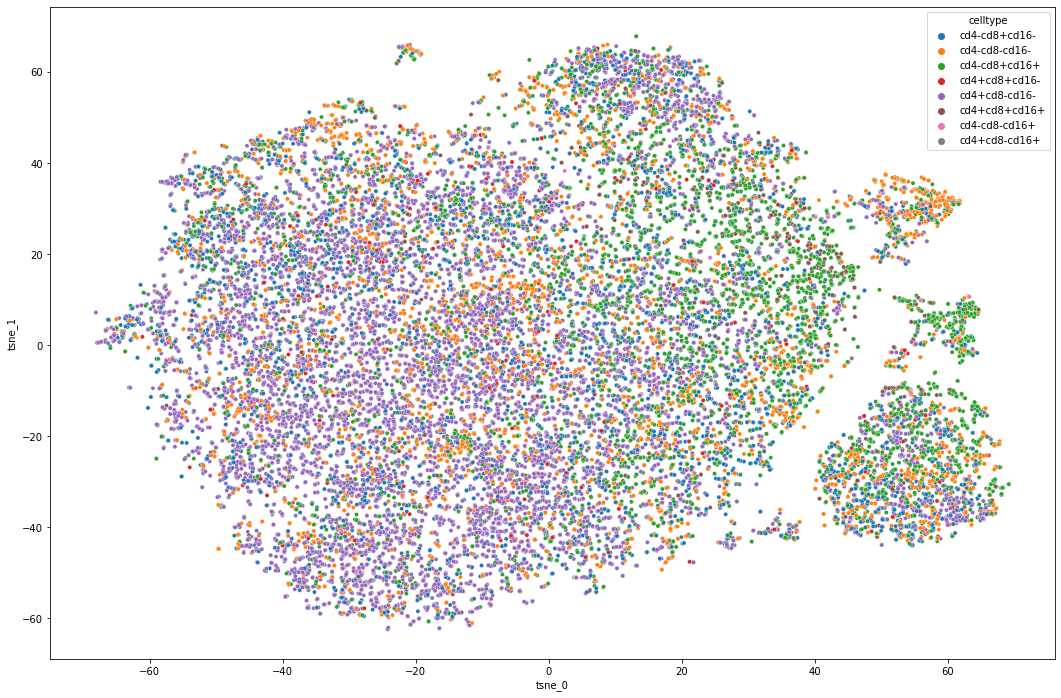

<IPython.core.display.Javascript object>

In [56]:
fig, ax = plt.subplots(figsize=[18, 12])
ax = sns.scatterplot(data=tsne_embs, x="tsne_0", y="tsne_1", hue="celltype", s=18)

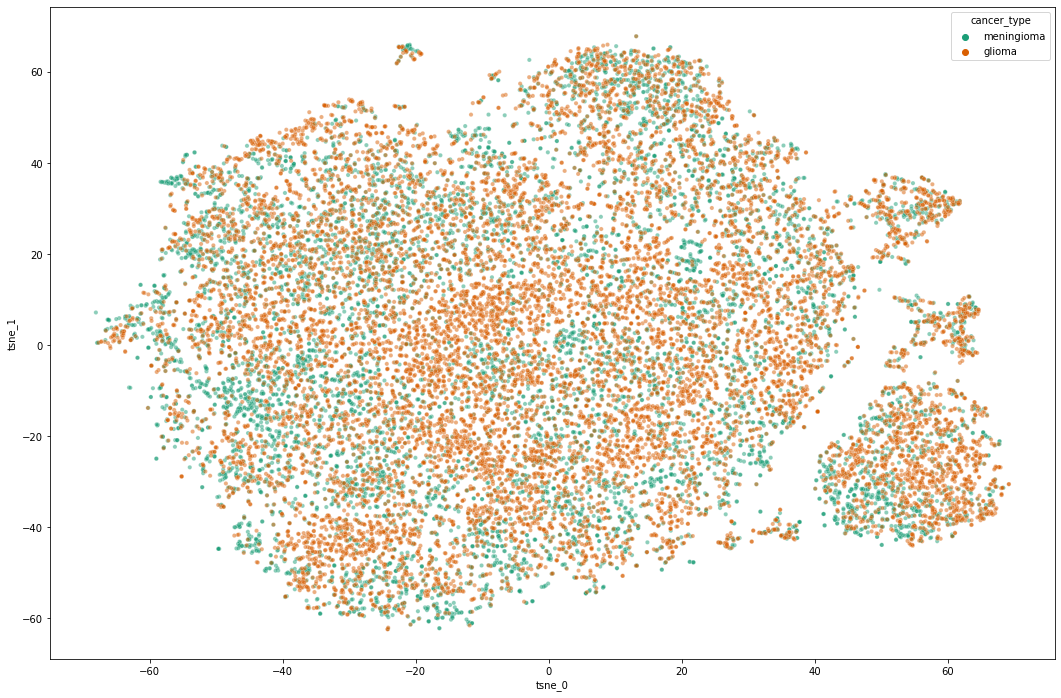

<IPython.core.display.Javascript object>

In [60]:
fig, ax = plt.subplots(figsize=[18, 12])
ax = sns.scatterplot(
    data=tsne_embs,
    x="tsne_0",
    y="tsne_1",
    hue="cancer_type",
    s=18,
    palette="Dark2",
    alpha=0.5,
)

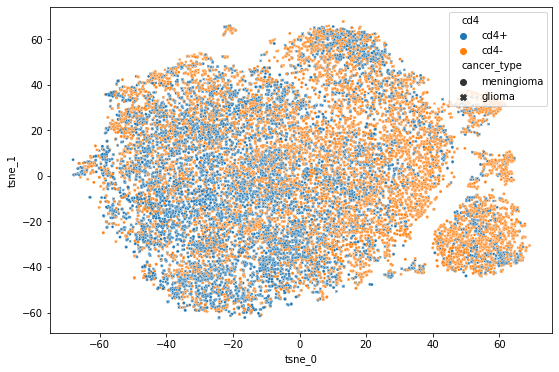

<IPython.core.display.Javascript object>

In [47]:
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=tsne_embs,
    x="tsne_0",
    y="tsne_1",
    hue="cd4",
    style="cancer_type",
    s=8,
    hue_order=["cd4+", "cd4-"],
)

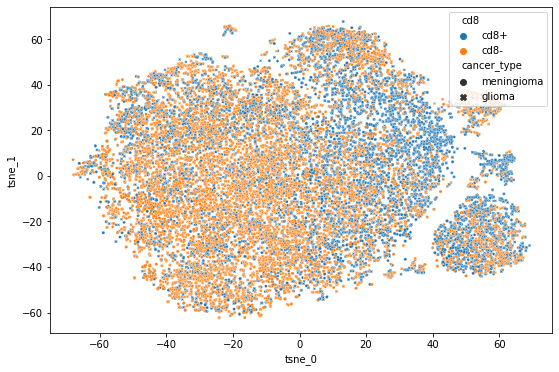

<IPython.core.display.Javascript object>

In [51]:
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=tsne_embs,
    x="tsne_0",
    y="tsne_1",
    hue="cd8",
    style="cancer_type",
    s=8,
    # palette="Accent",
)

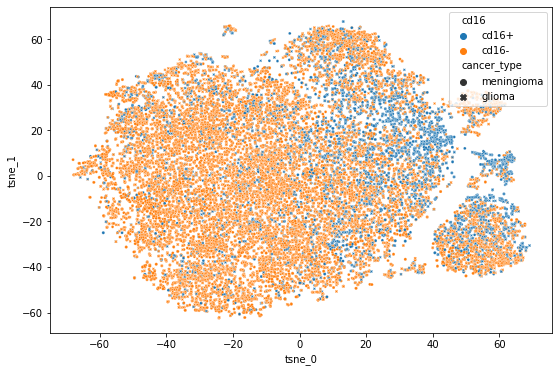

<IPython.core.display.Javascript object>

In [50]:
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=tsne_embs,
    x="tsne_0",
    y="tsne_1",
    hue="cd16",
    style="cancer_type",
    s=8,
    # palette="Dark2",
    hue_order=["cd16+", "cd16-"],
)

---

## 4. Classification




### 4.1. Meningioma

#### CD4 data

In [147]:
meningioma_nmco_feat = nmco_features.loc[
    nmco_features.cancer_type.isin(["meningioma", "glioma"])
]
meningioma_nmco_feat = meningioma_nmco_feat.loc[meningioma_nmco_feat.timepoint == 1]
meningioma_nmco_feat_sc = pd.DataFrame(
    StandardScaler().fit_transform(meningioma_nmco_feat.iloc[:, :-7]),
    index=meningioma_nmco_feat.index,
    columns=meningioma_nmco_feat.iloc[:, :-7].columns,
)

<IPython.core.display.Javascript object>

In [148]:
sampler = RandomUnderSampler(random_state=seed)
idc = np.array(list(range(len(meningioma_nmco_feat)))).reshape(-1, 1)
cd4_idc, _ = sampler.fit_resample(idc, meningioma_nmco_feat.loc[:, "cancer_type"])

cd4_data = meningioma_nmco_feat_sc.iloc[cd4_idc[:, 0]]
cd4_labels = meningioma_nmco_feat.loc[cd4_data.index, "cancer_type"]
cd4_data.describe()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,d75_radius,...,rel_ec_volume,hc_ec_ratio_3d,rdp_1,rdp_2,rdp_3,rdp_4,rdp_5,rdp_6,rdp_7,rdp_8
count,5900.000000,5900.000000,5900.000000,5900.000000,5900.000000,5900.000000,5900.000000,5900.000000,5900.000000,5900.000000,...,5900.000000,5900.000000,5900.000000,5900.000000,5900.000000,5900.000000,5900.000000,5900.000000,5900.000000,5900.000000
mean,-0.010857,-0.012652,0.001546,0.001779,-0.012702,-0.015854,-0.013029,0.002000,-0.009496,-0.011442,...,-0.055826,0.055754,-0.006644,-0.012364,-0.007440,-0.015792,-0.020984,-0.024104,-0.032897,-0.038128
std,0.992707,0.990166,1.000358,0.999665,0.994463,0.989379,0.986529,0.998540,0.989324,0.991822,...,0.998528,0.998986,0.989627,0.991886,0.996869,0.995533,0.997278,1.001030,0.999008,0.999531
min,-7.833420,-4.243999,-7.274406,-5.596082,-3.316283,-7.858607,-7.553808,-5.516931,-7.732759,-5.391743,...,-5.501885,-4.121731,-0.876235,-1.834019,-2.360184,-2.411244,-2.928066,-2.909392,-3.972691,-4.031640
25%,-0.643013,-0.681845,-0.606906,-0.472980,-0.661384,-0.638185,-0.627736,-0.476590,-0.591673,-0.640433,...,-0.632560,-0.560675,-0.718419,-0.722428,-0.718579,-0.685124,-0.666545,-0.711321,-0.681884,-0.700075
50%,0.058491,-0.133821,0.110672,0.145599,-0.206361,-0.066348,-0.065411,0.130750,0.025908,-0.180352,...,-0.055345,0.051137,-0.272531,-0.161610,-0.173699,-0.069667,-0.041500,-0.120270,-0.031897,-0.028610
75%,0.584618,0.414203,0.738553,0.683358,0.438284,0.539707,0.531318,0.669381,0.622449,0.478024,...,0.558571,0.629222,0.376312,0.525000,0.508929,0.585393,0.588856,0.530545,0.599753,0.626431
max,3.039879,12.744737,2.193643,2.357696,13.394264,8.542235,8.317286,4.324592,3.043121,12.970236,...,4.194856,5.618585,15.253317,13.219250,8.665630,6.136559,5.192529,4.933415,4.449087,4.081307


<IPython.core.display.Javascript object>

#### CD8 data

In [116]:
sampler = RandomUnderSampler(random_state=seed)
idc = np.array(list(range(len(meningioma_nmco_feat)))).reshape(-1, 1)
cd8_idc, _ = sampler.fit_resample(idc, meningioma_nmco_feat.loc[:, "cd8"])

cd8_data = meningioma_nmco_feat_sc.iloc[cd8_idc[:, 0]]
cd8_labels = meningioma_nmco_feat.loc[cd8_data.index, "cd8"]
cd8_data.describe()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,d75_radius,...,rel_ec_volume,hc_ec_ratio_3d,rdp_1,rdp_2,rdp_3,rdp_4,rdp_5,rdp_6,rdp_7,rdp_8
count,10502.000000,10502.000000,10502.000000,10502.000000,10502.000000,10502.000000,10502.000000,10502.000000,10502.000000,10502.000000,...,10502.000000,10502.000000,10502.000000,10502.000000,10502.000000,10502.000000,10502.000000,10502.000000,10502.000000,10502.000000
mean,-0.015422,0.041054,-0.044645,-0.050400,0.044716,0.009598,0.007310,-0.048754,-0.020012,0.033611,...,0.015490,-0.015390,-0.004045,-0.019055,-0.000215,-0.001509,0.003518,0.013989,0.007441,0.006430
std,1.013357,1.033100,1.020040,1.030295,1.037392,1.016186,1.015596,1.030758,1.013210,1.028315,...,1.014314,1.013861,0.997721,0.997749,1.008273,1.003195,1.003845,1.010590,1.003892,1.004692
min,-7.548955,-4.281683,-7.376475,-5.215963,-4.101605,-6.268442,-6.701695,-5.153129,-7.328909,-5.149027,...,-7.789218,-17.083634,-0.880013,-1.845641,-2.138189,-2.858914,-2.982649,-2.907665,-3.701572,-4.091713
25%,-0.588661,-0.578693,-0.652130,-0.520345,-0.620876,-0.621084,-0.610740,-0.519527,-0.610824,-0.607854,...,-0.589579,-0.615515,-0.731475,-0.755339,-0.754411,-0.726135,-0.713425,-0.730717,-0.716507,-0.706732
50%,0.074224,-0.195625,0.094274,0.111661,-0.150447,-0.020638,-0.029890,0.104359,0.029145,-0.106966,...,0.020706,-0.025216,-0.313637,-0.191326,-0.179108,-0.078881,-0.026664,-0.067592,0.032249,0.058000
75%,0.737109,0.570511,0.720005,0.636267,0.497042,0.599375,0.596194,0.624446,0.637835,0.528289,...,0.611634,0.587706,0.382794,0.528163,0.572773,0.636929,0.658478,0.670042,0.695734,0.710346
max,3.057207,8.870318,2.065835,2.583459,13.201952,6.615385,6.646095,4.294659,2.993728,11.529305,...,18.457577,8.080349,14.547463,12.819335,7.956054,5.699788,4.813567,4.458528,4.140679,3.810615


<IPython.core.display.Javascript object>

#### CD16 data

In [117]:
sampler = RandomUnderSampler(random_state=seed)
idc = np.array(list(range(len(meningioma_nmco_feat)))).reshape(-1, 1)
cd16_idc, _ = sampler.fit_resample(idc, meningioma_nmco_feat.loc[:, "cd16"])

cd16_data = meningioma_nmco_feat_sc.iloc[cd16_idc[:, 0]]
cd16_labels = meningioma_nmco_feat.loc[cd16_data.index, "cd16"]
cd16_data.describe()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,d75_radius,...,rel_ec_volume,hc_ec_ratio_3d,rdp_1,rdp_2,rdp_3,rdp_4,rdp_5,rdp_6,rdp_7,rdp_8
count,5862.000000,5862.000000,5862.000000,5862.000000,5862.000000,5862.000000,5862.000000,5862.000000,5862.000000,5862.000000,...,5862.000000,5862.000000,5862.000000,5862.000000,5862.000000,5862.000000,5862.000000,5862.000000,5862.000000,5862.000000
mean,-0.037020,0.187117,-0.171612,-0.186035,0.199335,0.065048,0.056384,-0.181869,-0.061584,0.157847,...,0.109312,-0.109009,0.013380,-0.059650,0.017696,0.005098,0.027537,0.082621,0.055819,0.058199
std,1.047124,1.142474,1.087862,1.128458,1.145858,1.062566,1.061863,1.123287,1.062789,1.124629,...,1.050554,1.046858,1.022413,1.014803,1.046153,1.036381,1.039778,1.050408,1.034530,1.028856
min,-5.726021,-4.281683,-5.246751,-5.215963,-3.783840,-6.268442,-6.701695,-5.153129,-7.328909,-4.911211,...,-5.691997,-17.083634,-0.879564,-1.867056,-2.099823,-2.708259,-2.982649,-2.983210,-3.701572,-4.091713
25%,-0.754382,-0.578693,-0.802976,-0.700148,-0.552168,-0.598089,-0.599364,-0.693118,-0.673619,-0.567989,...,-0.514120,-0.709187,-0.733078,-0.802485,-0.764329,-0.733604,-0.694648,-0.684643,-0.666008,-0.648159
50%,0.074224,-0.067935,-0.016820,-0.002894,-0.020078,0.032674,0.023519,-0.010286,0.005723,-0.009125,...,0.105946,-0.110558,-0.314134,-0.239054,-0.173213,-0.065587,0.006790,0.005250,0.085737,0.114762
75%,0.737109,0.698201,0.635245,0.573963,0.731672,0.700670,0.680150,0.561020,0.621916,0.716626,...,0.705693,0.511739,0.409208,0.482472,0.628541,0.653601,0.693627,0.775306,0.746164,0.769460
max,3.222928,8.870318,2.065835,2.583459,11.317752,5.699000,6.492596,2.714175,3.009364,7.959770,...,18.457577,5.846629,14.547463,12.819335,7.956054,5.699788,4.813567,4.458528,4.140679,3.810615


<IPython.core.display.Javascript object>

---

### Nuclei-level split

At first we will assess the performance of a RandomForest classifier evaluated on a balanced subset of the data that is split in a stratified way on the nuclei-level, i.e. nuclei from different conditions, individuals and time points will be included in the training and validation data. We assess the performance of the classifier using 10-fold cross-validation and computing the ROC-AUC.

#### CD4

In [149]:
features = np.array(cd4_data)
labels = np.array(cd4_labels)

<IPython.core.display.Javascript object>

In [150]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=10, random_state=seed)
skf = StratifiedKFold(4)


confusion_mtx = np.zeros([2, 2])
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    rfc.fit(X_train, y_train)
    confusion_mtx += confusion_matrix(y_test, rfc.predict(X_test), normalize="true")
confusion_mtx /= 4

<IPython.core.display.Javascript object>

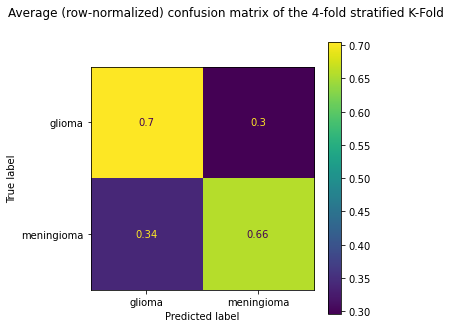

<IPython.core.display.Javascript object>

In [151]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_mtx,
    display_labels=["glioma", "meningioma"],
)
disp.plot(ax=ax)
fig.suptitle(
    "Average (row-normalized) confusion matrix of the 4-fold stratified K-Fold"
)
plt.show()

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :

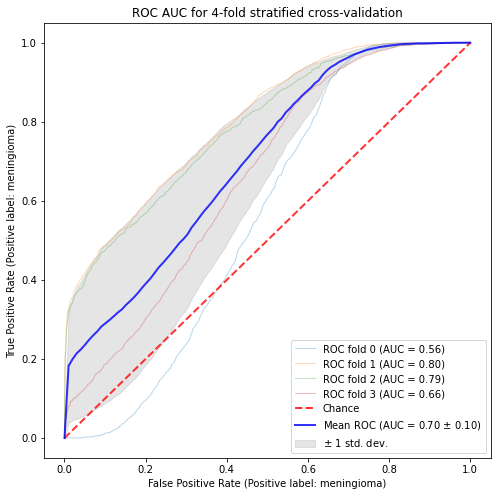

<IPython.core.display.Javascript object>

In [141]:
plot_roc_for_stratified_cv(
    features,
    labels,
    4,
    rfc,
    "ROC AUC for 4-fold stratified cross-validation",
    pos_label="meningioma",
)
plt.show()

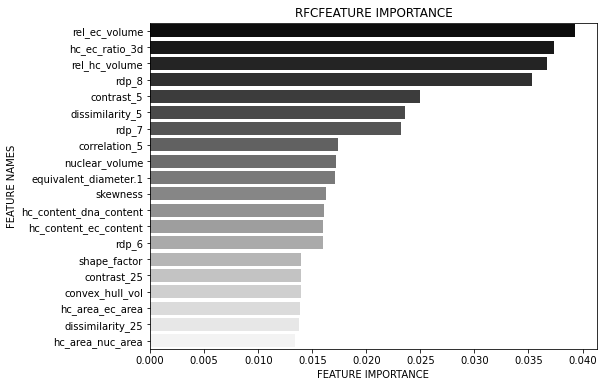

<IPython.core.display.Javascript object>

In [152]:
rfc = rfc.fit(features, labels)
plot_feature_importance(rfc.feature_importances_, cd4_data.columns, "RFC")

---

#### CD8

In [123]:
features = np.array(cd8_data)
labels = np.array(cd8_labels)

<IPython.core.display.Javascript object>

In [124]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=10, random_state=seed)
skf = StratifiedKFold(4)


confusion_mtx = np.zeros([2, 2])
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    rfc.fit(X_train, y_train)
    confusion_mtx += confusion_matrix(y_test, rfc.predict(X_test), normalize="true")
confusion_mtx /= 4

<IPython.core.display.Javascript object>

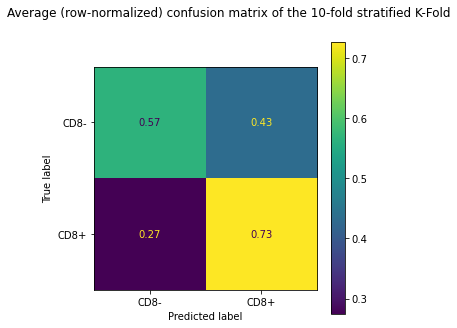

<IPython.core.display.Javascript object>

In [125]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_mtx,
    display_labels=["CD8-", "CD8+"],
)
disp.plot(ax=ax)
fig.suptitle(
    "Average (row-normalized) confusion matrix of the 10-fold stratified K-Fold"
)
plt.show()

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :

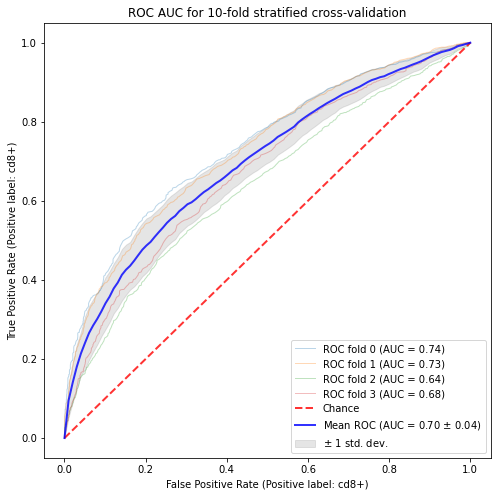

<IPython.core.display.Javascript object>

In [126]:
plot_roc_for_stratified_cv(
    features,
    labels,
    4,
    rfc,
    "ROC AUC for 10-fold stratified cross-validation",
    pos_label="cd8+",
)
plt.show()

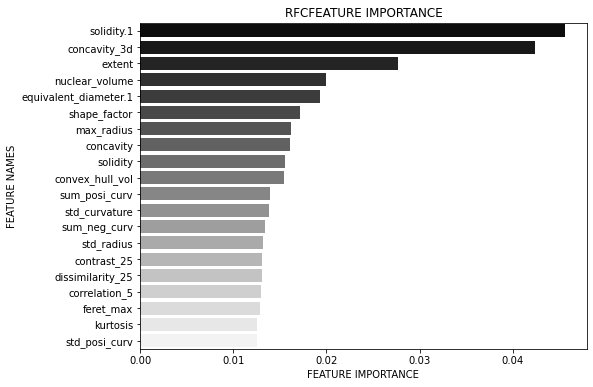

<IPython.core.display.Javascript object>

In [127]:
rfc = rfc.fit(features, labels)
plot_feature_importance(rfc.feature_importances_, cd8_data.columns, "RFC")

---

#### CD16

In [128]:
features = np.array(cd16_data)
labels = np.array(cd16_labels)

<IPython.core.display.Javascript object>

In [129]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=10, random_state=seed)
skf = StratifiedKFold(4)


confusion_mtx = np.zeros([2, 2])
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    rfc.fit(X_train, y_train)
    confusion_mtx += confusion_matrix(y_test, rfc.predict(X_test), normalize="true")
confusion_mtx /= 4

<IPython.core.display.Javascript object>

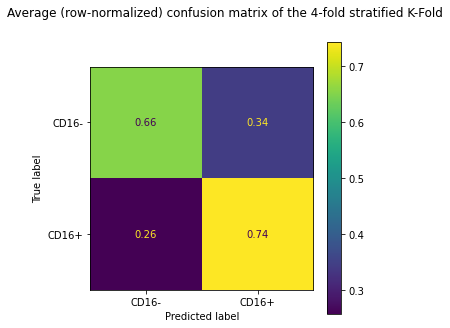

<IPython.core.display.Javascript object>

In [130]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_mtx,
    display_labels=["CD16-", "CD16+"],
)
disp.plot(ax=ax)
fig.suptitle(
    "Average (row-normalized) confusion matrix of the 4-fold stratified K-Fold"
)
plt.show()

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :

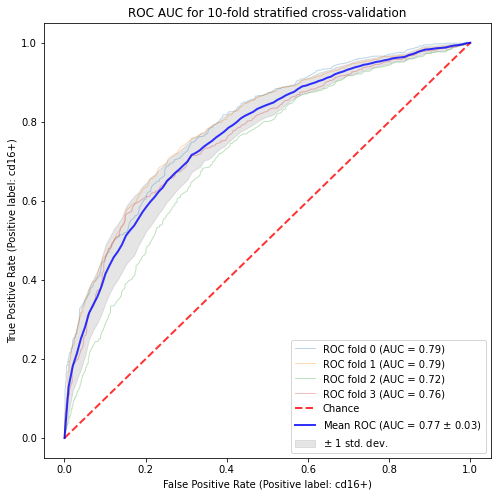

<IPython.core.display.Javascript object>

In [131]:
plot_roc_for_stratified_cv(
    features,
    labels,
    4,
    rfc,
    "ROC AUC for 10-fold stratified cross-validation",
    pos_label="cd16+",
)
plt.show()

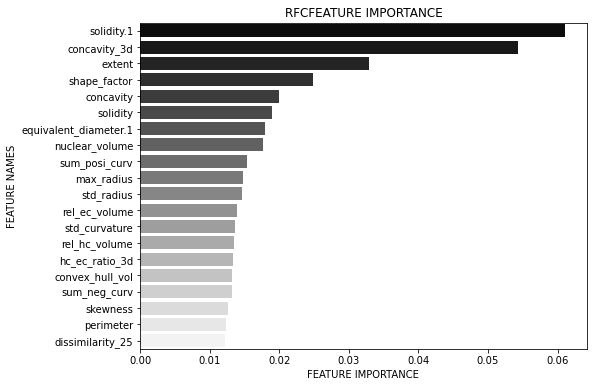

<IPython.core.display.Javascript object>

In [132]:
rfc = rfc.fit(features, labels)
plot_feature_importance(rfc.feature_importances_, cd16_data.columns, "RFC")